**CN included trainset for LDA+XGB CoPath**

In [ ]:
from scipy.stats import pearsonr  # or spearmanr if you prefer
def resilient_subgroup_visualization(inp_df,prob_cols, group_col,group_order,cohort='NACC',scatter_col='standardized_residual'):
    group_means = (
        inp_df
        .groupby(group_col)[prob_cols]
        .mean()
        .reindex(group_order)
    )
###################### GROUP MEAN LEVEL #####################
    # ------------------------------------------------------------
    # Plot heatmap
    # ------------------------------------------------------------
    plt.figure(figsize=(8, 5))

    sns.heatmap(
        group_means,
        cmap="Reds",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        vmin=0,
        vmax=1,
        cbar_kws={"label": "Mean predicted probability"}
    )

    plt.xlabel("Predicted pathology")
    plt.ylabel("Subgroup")
    plt.title(f"{cohort} Group-wise Mean Predicted Probability Distribution")
    plt.tight_layout()
    plt.show()
###################### SUBJECT LEVEL #####################
    # ------------------------------------------------------------
    # Sort: group first, then descending P(AD)
    # ------------------------------------------------------------
    inp_df[group_col] = pd.Categorical(
        inp_df[group_col],
        categories=group_order,
        ordered=True
    )

    df_sorted = (
        inp_df
        .sort_values([group_col, "P(AD)"], ascending=[True, False])
        .reset_index(drop=True)
    )


    heatmap_data = df_sorted[prob_cols]

    # ------------------------------------------------------------
    # Compute group positions for y-axis labels
    # ------------------------------------------------------------
    group_counts = (
        df_sorted[group_col]
        .value_counts()
        .reindex(group_order)
    )


    group_centers = {}
    start = 0

    for grp, count in group_counts.items():
        center = start + count / 2
        group_centers[grp] = center
        start += count

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        heatmap_data,
        cmap="Reds",
        vmin=0,
        vmax=1,
        yticklabels=False,
        cbar_kws={"label": "Predicted probability"}
    )

    # ------------------------------------------------------------
    # Horizontal lines between groups
    # ------------------------------------------------------------
    cum_sizes = np.cumsum(group_counts.values)

    for y in cum_sizes[:-1]:
        ax.hlines(y, *ax.get_xlim(), colors="black", linewidth=1.5)

    # ------------------------------------------------------------
    # TN subgroup labels on y-axis
    # ------------------------------------------------------------
    ax.set_yticks(list(group_centers.values()))
    ax.set_yticklabels(list(group_centers.keys()), rotation=0, fontsize=11)

    # ------------------------------------------------------------
    # Labels
    # ------------------------------------------------------------
    ax.set_xlabel("Predicted pathology")
    ax.set_ylabel("Subgroup")
    ax.set_title(f"{cohort} Subject-level Predicted Probability Heatmap\n(sorted by descending P(AD))")
    plt.tight_layout()
    plt.show()
    
###################### RADAR PLOT #####################
    topic_cols = [c for c in inp_df.columns if c.startswith("Topic_")]

    groups = inp_df[group_col].unique()
    n_groups = len(groups)
    n_topics = len(topic_cols)

    # ------------------------------------------------------------
    # Global max for shared axis
    # ------------------------------------------------------------
    global_max = (
        inp_df
        .groupby(group_col)[topic_cols]
        .mean()
        .values
        .max()
    )

    # ------------------------------------------------------------
    # Radar setup
    # ------------------------------------------------------------
    angles = np.linspace(0, 2 * np.pi, n_topics, endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    fig, axes = plt.subplots(
        1, n_groups,
        figsize=(4 * n_groups, 4),
        subplot_kw=dict(polar=True)
    )

    if n_groups == 1:
        axes = [axes]

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    # for ax, grp in zip(axes, groups):
    for ax, grp in zip(axes, group_order):
        print(ax,grp)

        grp_df = inp_df[inp_df[group_col] == grp]
        mean_topics = grp_df[topic_cols].mean().values
        mean_topics = np.concatenate([mean_topics, [mean_topics[0]]])

        ax.plot(angles, mean_topics, linewidth=2)
        ax.fill(angles, mean_topics, alpha=0.25)

        ax.set_title(grp, pad=20)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(topic_cols, fontsize=9)

        ax.set_ylim(0, global_max * 1.1)   # ✅ shared scale
        ax.set_yticklabels([])

    plt.suptitle(f"{cohort} Resilience Subgroup Topic Weight Profiles (shared radial scale)", fontsize=14)
    plt.tight_layout()
    plt.show()

###################### CORRELATION SCATTER #####################
    # -----------------------------
    # Example inputs
    # -----------------------------
    # inp_df: your dataframe
    # cols_to_corr: list of columns of probabilities to correlate
    # target_col: column to correlate against
    cols_to_corr = prob_cols
    target_col = scatter_col  # for example

    # -----------------------------
    # Plotting setup
    # -----------------------------
    n_cols = 3  # how many subplots per row
    n_rows = int(np.ceil(len(cols_to_corr) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()
    palette = sns.color_palette("tab10", n_colors=len(group_order))

    group_palette = dict(zip(group_order, palette))

    for ax, col in zip(axes, cols_to_corr):
        
        x = inp_df[col]
        y = inp_df[target_col]
        
        # Compute correlation
        r, p = pearsonr(x, y)
        
        # Scatter plot
        sns.scatterplot(
            x=x, y=y, hue=inp_df[group_col], palette=group_palette, ax=ax, s=60, alpha=0.8
        )
        
        # Fit line
        sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', ci=None)
        
        # Annotate r and p
        ax.text(0.05, 0.95, f"r={r:.2f}\np={p:.3f}",
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                fontsize = 13)
        
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        ax.set_title(f"{col} vs {target_col}")
        ax.set_xlim([0, 1])
        ax.set_ylim([-3, 4])

    # Remove empty axes if any
    for ax in axes[len(cols_to_corr):]:
        ax.remove()
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper right', title=group_col, bbox_to_anchor=(1.05, 1))
    plt.suptitle('NACC')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from data_processor import *
from lda_model import LDATopicModel
from classifier import TopicClassifier
from visualizer import *
from brain_visualizer import *

data_path = 'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data'

inp_df = pd.read_csv(os.path.join(data_path,'260128_wsev_smc_combined_cn_included.csv'))
inp_df = inp_df[inp_df['DX']!='HC'] # EXCLUDE WSEV HC

print(inp_df['DX'].value_counts())

df_nacc_resilience = pd.read_csv(data_path + '/nacc/NACC_resilience_inference.csv')
df_adni4_resilience = pd.read_csv(data_path + '/adni/ADNI4_resilience_inference.csv')
# df_nacc_resilience = pd.read_csv('C:/Users/BREIN/Desktop/stage_copath/20260122_NACC_linear_group.csv')

df_adni4_resilience = df_adni4_resilience.rename(columns={"FULL_ID": "SUBJ_ID"})
df_nacc_resilience = df_nacc_resilience.rename(columns={"subject_id" : "SUBJ_ID"})
nacc_raw = pd.read_csv(data_path + '/nacc/260120_NACC_VA_TAU_PATH_matched.csv')

In [ ]:
region_cols = nacc_raw.loc[:, 'VA/2':'VA/2035'].columns
# nacc_filtered = nacc_raw[nacc_raw['DX'] != 'Unknown']
# nacc_cn = nacc_filtered[nacc_filtered['DX'] == 'CN']

## DOWNSAMPLE LARGE DX 
N = 25
dx_col = "DX"
balanced_parts = []

for dx, g in inp_df.groupby(dx_col):
    if dx == 'AD':
        N=50
    elif dx == 'NC':
        N=50
    else: 
        N=25
    if len(g) > N:
        g = g.sample(n=N, replace=False, random_state=42)
    balanced_parts.append(g)

train_df = pd.concat(balanced_parts).reset_index(drop=True)


#### add mci to AD ####
# train_df['DX'] = train_df['DX'].replace({'MCI' : 'AD'})

print(train_df[dx_col].value_counts())

In [ ]:
# k = 20
k_list = range(4,26,2)
perplexities = []
cv_acc = []
for k in [8]:
    print('K-topics = ', k)
    labels = train_df["DX"].values
    ids = train_df["SUBJ_ID"].values

    lda = LDATopicModel(n_topics=k, alpha=1/k, beta=1/k)
    theta = lda.fit_transform(train_df[region_cols])
    classifier = TopicClassifier(n_splits=5)
    cv_results = classifier.cross_validate(theta, labels, ids, verbose=False)
    classifier.fit(theta, labels)
    print(f"k_topics {k}, CV ACC: {cv_results['accuracy']}")
    print(lda._theta.shape)
    
    perplexities.append(lda._perplexity)
    cv_acc.append(cv_results['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_list, perplexities, marker='o')
plt.xlabel("Number of topics (K)")
plt.ylabel("Perplexity")
plt.title("LDA Perplexity vs Number of Topics")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(k_list, cv_acc, marker='o')
plt.xlabel("Number of topics (K)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Downstream Classification Accuracy vs Number of Topics")
plt.grid(True)
plt.show()

print(k_list[np.argmin(perplexities)], np.min(perplexities))
print(k_list[np.argmax(cv_acc)], np.max(cv_acc))

In [ ]:
r2 = lda.get_topic_dataframe(region_names=region_cols)
d2 = r2.sum(axis=0)
r2.to_csv(f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled/lda_k_{k}_topic_patterns.csv')

In [ ]:
## Internal Visualization
dkt_labels = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/dkt_labels.csv')
rois = dkt_labels.iloc[0].tolist()

visualizer = CopathologyVisualizer(
    output_dir=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled'
)
fig_conf_mat = visualizer.plot_confusion_matrix(
    cm=classifier.get_confusion_matrix(),
    class_names=classifier._classes
)

fig_top_regions = visualizer.plot_top_regions_per_topic(
    topic_patterns = lda.get_topic_patterns(),
    region_names=rois,
    save=True
)

radar_plot = visualizer.plot_diagnosis_topic_profiles(
    theta=lda._theta,
    dx_labels = labels
)

probabilities_heatmap = visualizer.plot_probability_heatmap(
    proba_df=classifier.get_cv_results(),
    dx_order = ["NC", "AD", "DLB", "PD", "SVAD", "bvFTD", "nfvPPA", "svPPA"]
)

In [ ]:
## Surface Mapping ##
from atlas_vis import DKTAtlas62ROIPlotter
plotter_62  = DKTAtlas62ROIPlotter(
    cmap='Reds',
    clim=(0, 0.1),  
    window_size=(1200, 1000),
    nan_color='lightgray',
    background='white',
    template_key='pial'
)
os.makedirs(f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled/topicwise',exist_ok=True)

topic_df = pd.DataFrame(
    lda.get_topic_patterns().T,
    index=region_cols,
    columns=[f"Topic_{k}" for k in range(k)]
)

df = topic_df.tail(62).reset_index(drop=True)

print(len(df))
for col in df.columns: ##################
    print(col)
    l_values = df.loc[:30,col].to_list()
    r_values = df.loc[31:,col].to_list()
    print(len(l_values))
    print(len(r_values))
    print(np.min(l_values+r_values))
    print(np.max(l_values+r_values))

    plotter_62(l_values, r_values, save_path=f'C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/results/train_cn_added/topics_{k}_downsampled/topicwise/{col}.png')

**NACC Inference**

In [ ]:
# NACC CN included inference ##
nacc_raw = pd.read_csv(os.path.join(data_path, 'nacc/260120_NACC_VA_TAU_PATH_matched.csv'))
linear_resilience = pd.read_csv(os.path.join(data_path, 'nacc/20260122_NACC_linear_group.csv'))
region_cols = nacc_raw.loc[:, 'VA/2':'VA/2035'].columns
pathology_cols = nacc_raw.loc[:, 'NACC_AD':'NACC_svPPA'].columns
nacc_filtered = nacc_raw[nacc_raw['DX'] != 'Unknown']

nacc_cn = nacc_filtered[nacc_filtered['DX']=='CN']

print(nacc_cn.shape)
print(nacc_filtered.shape)

nacc_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='subject_id'
)
nacc_prep.fit_baseline(hc_data=nacc_cn)
nacc_Z = nacc_prep.compute_atrophy_scores(data=nacc_filtered)
# print(type(nacc_Z))

nacc_theta = lda.transform(nacc_Z)
y_pred = classifier.predict(nacc_theta)
y_proba = classifier.predict_proba(nacc_theta)

nacc_results = pd.DataFrame(nacc_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(nacc_results.shape)
subj_col = nacc_prep.subject_col
if subj_col in nacc_filtered.columns:
    nacc_results.insert(0, "SUBJ_ID", nacc_filtered[subj_col].values)

nacc_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    nacc_results[f"P({dx})"] = y_proba[:,i]
nacc_results = nacc_results.merge(
    linear_resilience[["FULL_ID", "linear_group", "standardized_residual"]],
    left_on="SUBJ_ID",
    right_on='FULL_ID',
    how="left"
)
nacc_results = nacc_results.dropna(subset=['linear_group'])
nacc_results = nacc_results.merge(
    nacc_raw[["subject_id", "DX", 'NACC_AD', 'NACC_PD', 'NACC_VD', 'NACC_LBD', 'NACC_SVAD', 'NACC_PCA', 'NACC_bvFTD']],
    left_on="SUBJ_ID",
    right_on="subject_id",
    how="left"
)
nacc_results = nacc_results.drop(columns=["subject_id"])

print(nacc_results['DX'].value_counts())
nacc_results_cn = nacc_results[nacc_results['DX']=='CN']
nacc_results_imci = nacc_results[nacc_results['DX']=='IMCI']
nacc_results_mci = nacc_results[nacc_results['DX']=='MCI']
nacc_results_ad = nacc_results[nacc_results['DX']=='AD']


In [ ]:
status_cols = ['NACC_AD', 'NACC_PD', 'NACC_VD', 'NACC_LBD', 'NACC_PCA']  # example


# -----------------------------
# Prepare data: proportion of positives and negatives
# -----------------------------
prop_nacc_results_list = []

for col in status_cols:
    # Compute proportion of positives per group
    pos = nacc_results.groupby(group_col)[col].mean()
    neg = 1 - pos  # proportion of negatives
    
    temp_nacc_results = pd.DataFrame({
        'Group': pos.index,
        'Positive': pos.values,
        'Negative': neg.values,
        'Condition': col
    })
    prop_nacc_results_list.append(temp_nacc_results)

# Combine all conditions for plotting
plot_nacc_results = pd.concat(prop_nacc_results_list)

# -----------------------------
# Plot stacked barplot
# -----------------------------
conditions = plot_nacc_results['Condition'].unique()
n_cols = 2
n_rows = (len(conditions) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

colors = {'Positive':'blue', 'Negative':'red'}

for ax, cond in zip(axes, conditions):
    nacc_results_cond = plot_nacc_results[plot_nacc_results['Condition'] == cond].set_index('Group')
    nacc_results_cond[['Negative','Positive']].plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=[colors['Negative'], colors['Positive']],
        legend=False
    )
    ax.set_ylabel('Proportion')
    ax.set_title(cond)
    ax.set_ylim(0,1)

# Single legend for figure
handles = [plt.Rectangle((0,0),1,1,color=colors[c]) for c in colors]
fig.legend(handles, colors.keys(), loc='upper right', title='Status')

# Remove unused axes
for ax in axes[len(conditions):]:
    ax.remove()
plt.suptitle('NACC Pathology Positivity Proportions')
plt.tight_layout()
plt.show()

In [ ]:
# prob_cols = nacc_results.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
# group_col = 'TN_group'
group_col = 'linear_group'
group_order = ['Resilient', 'Canonical', 'Vulnerable']
plot_df = nacc_results_ad


In [ ]:
group_means = (
    plot_df
    .groupby(group_col)[prob_cols]
    .mean()
    .reindex(group_order)
)

# ------------------------------------------------------------
# Plot heatmap
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))

sns.heatmap(
    group_means,
    cmap="Reds",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Mean predicted probability"}
)

plt.xlabel("Predicted pathology")
plt.ylabel("Subgroup")
plt.title("NACC Group-wise Mean Predicted Probability Distribution")

plt.tight_layout()

plt.show()

In [ ]:
# ------------------------------------------------------------
# Sort: group first, then descending P(AD)
# ------------------------------------------------------------
plot_df[group_col] = pd.Categorical(
    plot_df[group_col],
    categories=group_order,
    ordered=True
)

nacc_sorted = (
    plot_df
    .sort_values([group_col, "P(AD)"], ascending=[True, False])
    .reset_index(drop=True)
)


heatmap_data = nacc_sorted[prob_cols]

# ------------------------------------------------------------
# Compute group positions for y-axis labels
# ------------------------------------------------------------
group_counts = (
    nacc_sorted[group_col]
    .value_counts()
    .reindex(group_order)
)


group_centers = {}
start = 0

for grp, count in group_counts.items():
    center = start + count / 2
    group_centers[grp] = center
    start += count

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    heatmap_data,
    cmap="Reds",
    vmin=0,
    vmax=1,
    yticklabels=False,
    cbar_kws={"label": "Predicted probability"}
)

# ------------------------------------------------------------
# Horizontal lines between groups
# ------------------------------------------------------------
cum_sizes = np.cumsum(group_counts.values)

for y in cum_sizes[:-1]:
    ax.hlines(y, *ax.get_xlim(), colors="black", linewidth=1.5)

# ------------------------------------------------------------
# TN subgroup labels on y-axis
# ------------------------------------------------------------
ax.set_yticks(list(group_centers.values()))
ax.set_yticklabels(list(group_centers.keys()), rotation=0, fontsize=11)

# ------------------------------------------------------------
# Labels
# ------------------------------------------------------------
ax.set_xlabel("Predicted pathology")
ax.set_ylabel("Subgroup")
ax.set_title("Subject-level Predicted Probability Heatmap\n(sorted by descending P(AD))")

plt.tight_layout()
plt.show()

In [ ]:
topic_cols = [c for c in plot_df.columns if c.startswith("Topic_")]

groups = plot_df[group_col].unique()
n_groups = len(groups)
n_topics = len(topic_cols)

# ------------------------------------------------------------
# Global max for shared axis
# ------------------------------------------------------------
global_max = (
    plot_df
    .groupby(group_col)[topic_cols]
    .mean()
    .values
    .max()
)

# ------------------------------------------------------------
# Radar setup
# ------------------------------------------------------------
angles = np.linspace(0, 2 * np.pi, n_topics, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig, axes = plt.subplots(
    1, n_groups,
    figsize=(4 * n_groups, 4),
    subplot_kw=dict(polar=True)
)

if n_groups == 1:
    axes = [axes]

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
# for ax, grp in zip(axes, groups):
for ax, grp in zip(axes, ['Vulnerable', 'Canonical', 'Resilient']):

    grp_df = plot_df[plot_df[group_col] == grp]
    mean_topics = grp_df[topic_cols].mean().values
    mean_topics = np.concatenate([mean_topics, [mean_topics[0]]])

    ax.plot(angles, mean_topics, linewidth=2)
    ax.fill(angles, mean_topics, alpha=0.25)

    ax.set_title(grp, pad=20)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(topic_cols, fontsize=9)

    ax.set_ylim(0, global_max * 1.1)   # ✅ shared scale
    ax.set_yticklabels([])

plt.suptitle("Resilience Subgroup Topic Weight Profiles (shared radial scale)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
## Correlation Subplots ##
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr  # or spearmanr if you prefer
import numpy as np

# -----------------------------
# Example inputs
# -----------------------------
# plot_df: your dataframe
# cols_to_corr: list of columns of probabilities to correlate
# target_col: column to correlate against
cols_to_corr = prob_cols
target_col = 'standardized_residual'  # for example

# -----------------------------
# Plotting setup
# -----------------------------
n_cols = 3  # how many subplots per row
n_rows = int(np.ceil(len(cols_to_corr) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
palette = sns.color_palette("tab10", n_colors=len(group_order))

group_palette = dict(zip(group_order, palette))

for ax, col in zip(axes, cols_to_corr):
    
    x = plot_df[col]
    y = plot_df[target_col]
    
    # Compute correlation
    r, p = pearsonr(x, y)
    
    # Scatter plot
    sns.scatterplot(
        x=x, y=y, hue=plot_df[group_col], palette=group_palette, ax=ax, s=60, alpha=0.8
    )
    
    # Fit line
    sns.regplot(x=x, y=y, ax=ax, scatter=False, color='red', ci=None)
    
    # Annotate r and p
    ax.text(0.05, 0.95, f"r={r:.2f}\np={p:.3f}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
            fontsize = 13)
    
    ax.set_xlabel(col)
    ax.set_ylabel(target_col)
    ax.set_title(f"{col} vs {target_col}")
    ax.set_xlim([0, 1])
    ax.set_ylim([-3, 4])

# Remove empty axes if any
for ax in axes[len(cols_to_corr):]:
    ax.remove()
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', title=group_col, bbox_to_anchor=(1.05, 1))
plt.suptitle('NACC')
plt.tight_layout()
plt.show()

**STAGE MODEL INFERENCE**

In [ ]:
stage_input_df = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/All.diff.260115.allvolume.NDadded.cohortwise.csv')
print(stage_input_df.shape)
stage_region_cols = stage_input_df.loc[:, 'NDVA/2':'NDVA/2035'].columns
stage_input_df = stage_input_df.dropna(subset=stage_region_cols)

# stage_Z = stage_input_df[['FULL_ID', 'COHORT'] +  stage_region_cols] 
stage_Z = stage_input_df[stage_region_cols].values
stage_Z[stage_Z<0] = 0
print(stage_Z.shape)
stage_theta = lda.fit_transform(stage_Z)
print(stage_theta.shape)

In [ ]:
stage_results = pd.DataFrame(stage_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
# stage_results.insert(
#     0,
#     "SUBJ_ID",
#     stage_input_df["FULL_ID"].values,
# )

stage_concat = pd.concat(
    [stage_input_df.reset_index(drop=True),
     stage_results.reset_index(drop=True)],
    axis=1
)
stage_concat.to_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/All.diff.260115.allvolume.NDadded.cohortwise_lda_topic_added_k_8_param.csv', index=False)

**NACC STAGE INFERENCE VULNERABILITY**

In [ ]:
# NACC CN included inference ##
nacc_aa_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/nacc/260203_STAGE_PRED_GT_NACC.csv')
nacc_aa_raw = nacc_aa_raw[nacc_aa_raw['DX']!='Unknown']
order = {'low': 0, 'mid': 1, 'high': 2}
gt_num = nacc_aa_raw['TAU/stage_aa_gt'].map(order)
pred_num = nacc_aa_raw['TAU/stage_aa_pred'].map(order)
nacc_aa_raw['TAU/stage_res_subgroup'] = np.select(
    [
        pred_num > gt_num,   # predicted worse than GT
        pred_num == gt_num,  # correct
        pred_num < gt_num    # predicted better than GT
    ],
    [
        'vulnerable',
        'canonical',
        'resilient'
    ],
    default=np.nan
)
region_cols = nacc_aa_raw.loc[:, 'VA/2':'VA/2035'].columns
nacc_aa_cn = nacc_aa_raw[nacc_aa_raw['DX']=='CN']

print(nacc_aa_cn.shape)
print(nacc_aa_raw.shape)

nacc_aa_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='subject_id'
)
nacc_aa_prep.fit_baseline(hc_data=nacc_aa_cn)
nacc_Z = nacc_aa_prep.compute_atrophy_scores(data=nacc_aa_raw)
nacc_theta = lda.transform(nacc_Z)
y_pred = classifier.predict(nacc_theta)
y_proba = classifier.predict_proba(nacc_theta)

nacc_results = pd.DataFrame(nacc_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(nacc_results.shape)
subj_col = nacc_aa_prep.subject_col
if subj_col in nacc_aa_raw.columns:
    nacc_results.insert(0, "SUBJ_ID", nacc_aa_raw[subj_col].values)
    
nacc_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    nacc_results[f"P({dx})"] = y_proba[:,i]

nacc_results = nacc_results.merge(
    nacc_aa_raw[["subject_id", "DX", 'TAU/NEO_SUVR', 'TAU/MTL_SUVR', 'TAU/stage_aa_gt', 'TAU/stage_aa_pred', 'TAU/stage_res_subgroup']],
    left_on="SUBJ_ID",
    right_on="subject_id",
    how="left"
)
nacc_results = nacc_results.drop(columns=["subject_id"])

print(nacc_results['DX'].value_counts())
nacc_results_cn = nacc_results[nacc_results['DX']=='CN']
nacc_results_imci = nacc_results[nacc_results['DX']=='IMCI']
nacc_results_mci = nacc_results[nacc_results['DX']=='MCI']
nacc_results_ad = nacc_results[nacc_results['DX']=='AD']

In [ ]:
# prob_cols = nacc_results_mci.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
group_col = 'TAU/stage_res_subgroup'

plot_df = nacc_results_ad
group_order = ['resilient', 'canonical', 'vulnerable']

# plot_df = plot_df[plot_df[group_col]!='canonical']
# group_order = ['resilient', 'vulnerable']

print(plot_df[group_col].value_counts())

In [ ]:
resilient_subgroup_visualization(
    inp_df=plot_df,
    prob_cols=prob_cols,
    group_col=group_col,
    group_order=group_order,
    cohort='NACC',
    scatter_col='TAU/NEO_SUVR'
)

**ADNI3 STAGE INFERENCE**

In [ ]:
adni3_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/ptau_volume_model/ADNI_3.csv')
region_cols = adni3_raw.loc[:, 'VA/2':'VA/2035'].columns
adni3_raw['TAU/stage_aa_gt'] = (
    adni3_raw[['tau_stage_aa/low', 'tau_stage_aa/mid', 'tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('tau_stage_aa/', '', regex=False)
)
adni3_raw['TAU/stage_aa_pred'] = (
    adni3_raw[['pred_tau_stage_aa/low', 'pred_tau_stage_aa/mid', 'pred_tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('pred_tau_stage_aa/', '', regex=False)
)
adni3_raw = adni3_raw.dropna(subset='TAU/stage_aa_gt')
order = {'low': 0, 'mid': 1, 'high': 2}
gt_num = adni3_raw['TAU/stage_aa_gt'].map(order)
pred_num = adni3_raw['TAU/stage_aa_pred'].map(order)
adni3_raw['TAU/stage_res_subgroup'] = np.select(
    [
        pred_num > gt_num,   # predicted worse than GT
        pred_num == gt_num,  # correct
        pred_num < gt_num    # predicted better than GT
    ],
    [
        'vulnerable',
        'canonical',
        'resilient'
    ],
    default=np.nan
)
adni3_cn = adni3_raw[adni3_raw['DX']=='CN']
print(adni3_raw['TAU/stage_res_subgroup'].value_counts())


adni3_aa_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='FULL_ID'
)
adni3_aa_prep.fit_baseline(hc_data=adni3_cn)
adni3_Z = adni3_aa_prep.compute_atrophy_scores(data=adni3_raw)
adni3_theta = lda.transform(adni3_Z)
y_pred = classifier.predict(adni3_theta)
y_proba = classifier.predict_proba(adni3_theta)

adni3_results = pd.DataFrame(adni3_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(adni3_results.shape)
subj_col = adni3_aa_prep.subject_col
if subj_col in adni3_raw.columns:
    adni3_results.insert(0, "SUBJ_ID", adni3_raw[subj_col].values)
    
adni3_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    adni3_results[f"P({dx})"] = y_proba[:,i]

adni3_results = adni3_results.merge(
    adni3_raw[["FULL_ID", "DX", 'tau_z/Neo','TAU/stage_aa_gt', 'TAU/stage_aa_pred', 'TAU/stage_res_subgroup']],
    left_on="SUBJ_ID",
    right_on="FULL_ID",
    how="left"
)
adni3_results = adni3_results.drop(columns=["FULL_ID"])

print(adni3_results['DX'].value_counts())
adni3_results_cn = adni3_results[adni3_results['DX']=='CN']
adni3_results_mci = adni3_results[adni3_results['DX']=='MCI']
adni3_results_ad = adni3_results[adni3_results['DX']=='Dementia']

In [ ]:
# prob_cols = adni3_results_mci.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
group_col = 'TAU/stage_res_subgroup'

plot_df = adni3_results_ad
# group_order = ['resilient', 'canonical', 'vulnerable']

plot_df = plot_df[plot_df[group_col]!='canonical']
group_order = ['resilient', 'vulnerable']

print(plot_df[group_col].value_counts())

In [ ]:
resilient_subgroup_visualization(
    inp_df=plot_df,
    prob_cols=prob_cols,
    group_col=group_col,
    group_order=group_order,
    cohort='ADNI3',
    scatter_col='tau_z/Neo'
)

**ADNI4 STAGE INFERENCE**

In [ ]:
adni4_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/ptau_volume_model/ADNI4_3.csv')
region_cols = adni4_raw.loc[:, 'VA/2':'VA/2035'].columns
adni4_raw['TAU/stage_aa_gt'] = (
    adni4_raw[['tau_stage_aa/low', 'tau_stage_aa/mid', 'tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('tau_stage_aa/', '', regex=False)
)
adni4_raw['TAU/stage_aa_pred'] = (
    adni4_raw[['pred_tau_stage_aa/low', 'pred_tau_stage_aa/mid', 'pred_tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('pred_tau_stage_aa/', '', regex=False)
)
adni4_raw = adni4_raw.dropna(subset='TAU/stage_aa_gt')
order = {'low': 0, 'mid': 1, 'high': 2}
gt_num = adni4_raw['TAU/stage_aa_gt'].map(order)
pred_num = adni4_raw['TAU/stage_aa_pred'].map(order)
adni4_raw['TAU/stage_res_subgroup'] = np.select(
    [
        pred_num > gt_num,   # predicted worse than GT
        pred_num == gt_num,  # correct
        pred_num < gt_num    # predicted better than GT
    ],
    [
        'vulnerable',
        'canonical',
        'resilient'
    ],
    default=np.nan
)
adni4_cn = adni4_raw[adni4_raw['DX']=='CN']
print(adni4_raw['TAU/stage_res_subgroup'].value_counts())


adni4_aa_prep = DataProcessor(
    region_cols=region_cols,
    dx_col = 'DX',
    subject_col='FULL_ID'
)
adni4_aa_prep.fit_baseline(hc_data=adni4_cn)
adni4_Z = adni4_aa_prep.compute_atrophy_scores(data=adni4_raw)
adni4_theta = lda.transform(adni4_Z)
y_pred = classifier.predict(adni4_theta)
y_proba = classifier.predict_proba(adni4_theta)

adni4_results = pd.DataFrame(adni4_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(adni4_results.shape)
subj_col = adni4_aa_prep.subject_col
if subj_col in adni4_raw.columns:
    adni4_results.insert(0, "SUBJ_ID", adni4_raw[subj_col].values)
    
adni4_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    adni4_results[f"P({dx})"] = y_proba[:,i]

adni4_results = adni4_results.merge(
    adni4_raw[["FULL_ID", "DX", 'tau_z/Neo','TAU/stage_aa_gt', 'TAU/stage_aa_pred', 'TAU/stage_res_subgroup']],
    left_on="SUBJ_ID",
    right_on="FULL_ID",
    how="left"
)
adni4_results = adni4_results.drop(columns=["FULL_ID"])

print(adni4_results['DX'].value_counts())
adni4_results_cn = adni4_results[adni4_results['DX']=='CN']
adni4_results_mci = adni4_results[adni4_results['DX']=='MCI']
adni4_results_ad = adni4_results[adni4_results['DX']=='AD']

In [ ]:
# prob_cols =adni4_results_mci.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
group_col = 'TAU/stage_res_subgroup'

plot_df =adni4_results_ad
group_order = ['resilient', 'canonical', 'vulnerable']

# plot_df = plot_df[plot_df[group_col]!='canonical']
# group_order = ['resilient', 'vulnerable']

print(plot_df[group_col].value_counts())

In [ ]:
resilient_subgroup_visualization(
    inp_df=plot_df,
    prob_cols=prob_cols,
    group_col=group_col, 
    group_order=group_order,
    cohort='ADNI4',
    scatter_col='tau_z/Neo'
)

**A4 INFERENCE**

In [67]:
a4_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/A4/A4_external_260203.add_tau_p.va_area_lobe.csv')
a4_stage_inf = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/A4/inferenced.csv')
region_cols = a4_raw.loc[:, 'VA_z/2':'VA_z/2035'].columns

a4_inp_df = a4_stage_inf.merge(a4_raw, on='FULL_ID', how='left', suffixes=('','_drop'))
a4_inp_df = a4_inp_df.dropna(subset=region_cols)

a4_inp_df['TAU/stage_aa_gt'] = (
    a4_inp_df[['tau_stage_aa/low', 'tau_stage_aa/mid', 'tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('tau_stage_aa/', '', regex=False)
)
a4_inp_df['TAU/stage_aa_pred'] = (
    a4_inp_df[['pred_tau_stage_aa/low', 'pred_tau_stage_aa/mid', 'pred_tau_stage_aa/high']]
    .idxmax(axis=1)
    .str.replace('pred_tau_stage_aa/', '', regex=False)
)
a4_inp_df = a4_inp_df.dropna(subset='TAU/stage_aa_gt')
order = {'low': 0, 'mid': 1, 'high': 2}
gt_num = a4_inp_df['TAU/stage_aa_gt'].map(order)
pred_num = a4_inp_df['TAU/stage_aa_pred'].map(order)
a4_inp_df['TAU/stage_res_subgroup'] = np.select(
    [
        pred_num > gt_num,   # predicted worse than GT
        pred_num == gt_num,  # correct
        pred_num < gt_num    # predicted better than GT
    ],
    [
        'vulnerable',
        'canonical',
        'resilient'
    ],
    default=np.nan
)

a4_Z = a4_inp_df[region_cols].values
a4_Z = -a4_Z
a4_Z[a4_Z<0] = 0

print(a4_Z.shape)
a4_theta = lda.fit_transform(a4_Z)
print(stage_theta.shape)
y_pred = classifier.predict(a4_theta)
y_proba = classifier.predict_proba(a4_theta)


a4_results = pd.DataFrame(a4_theta, columns=[f"Topic_{k}" for k in range(lda.n_topics)])
print(a4_results.shape)
if "FULL_ID" in a4_inp_df.columns:
    a4_results.insert(0, "SUBJ_ID", a4_inp_df[subj_col].values)
    
a4_results['pred_DX'] = y_pred
for i, dx in enumerate(classifier.classes):
    a4_results[f"P({dx})"] = y_proba[:,i]

a4_results = a4_results.merge(
    a4_inp_df[["FULL_ID", "DX", 'TAU/stage_aa_gt', 'TAU/stage_aa_pred', 'TAU/stage_res_subgroup']],
    left_on="SUBJ_ID",
    right_on="FULL_ID",
    how="left"
)
a4_results = a4_results.drop(columns=["FULL_ID"])

C:\Users\WooSikKim\AppData\Local\Temp\ipykernel_8824\985213622.py:1: DtypeWarning: Columns (309) have mixed types. Specify dtype option on import or set low_memory=False.
  a4_raw = pd.read_csv('C:/Users/WooSikKim/Desktop/Research/projects/co_pathology/scripts/stage_copath/data/stage_data/A4/A4_external_260203.add_tau_p.va_area_lobe.csv')


(376, 95)
(376, 8)
(376, 8)


In [68]:
# prob_cols =a4_results_mci.loc[:,'P(AD)':'P(svPPA)'].columns
prob_cols = ['P(NC)', 'P(AD)', 'P(PD)', 'P(DLB)', 'P(SVAD)', 'P(bvFTD)', 'P(nfvPPA)', 'P(svPPA)']
group_col = 'TAU/stage_res_subgroup'

plot_df =a4_results
group_order = ['resilient', 'canonical', 'vulnerable']

# plot_df = plot_df[plot_df[group_col]!='canonical']
# group_order = ['resilient', 'vulnerable']

print(plot_df[group_col].value_counts())

TAU/stage_res_subgroup
canonical     289
vulnerable     44
resilient      43
Name: count, dtype: int64


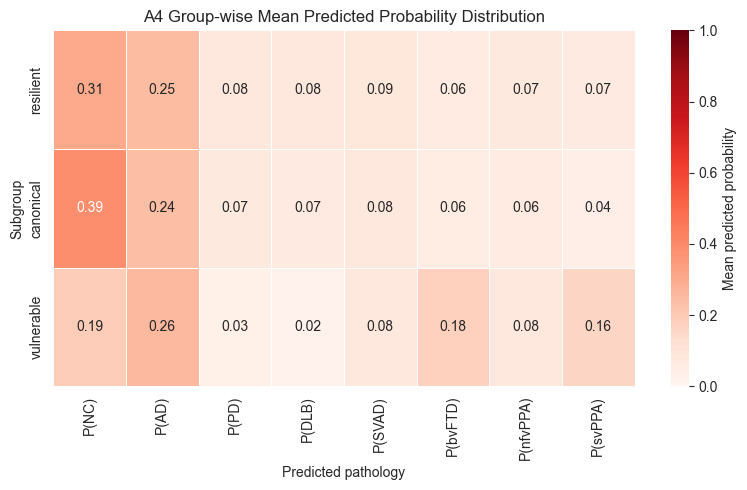

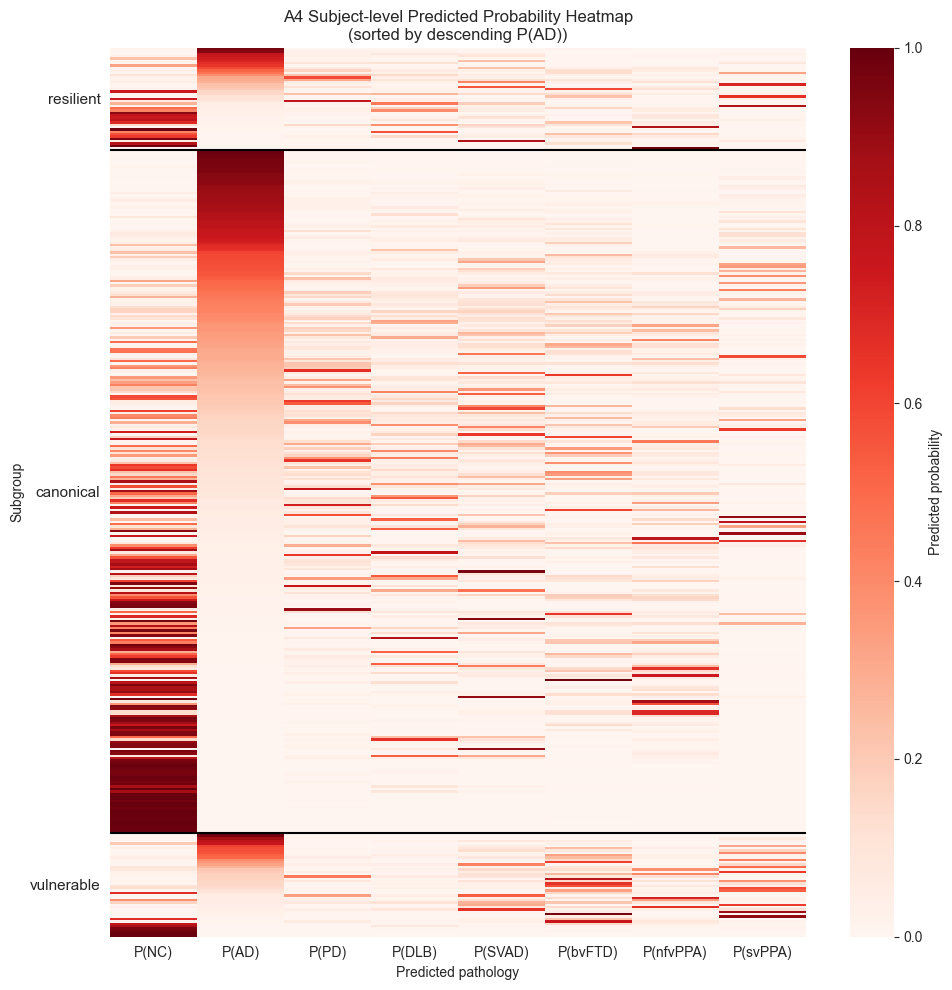

PolarAxes(0.125,0.11;0.227941x0.77) resilient
PolarAxes(0.398529,0.11;0.227941x0.77) canonical
PolarAxes(0.672059,0.11;0.227941x0.77) vulnerable


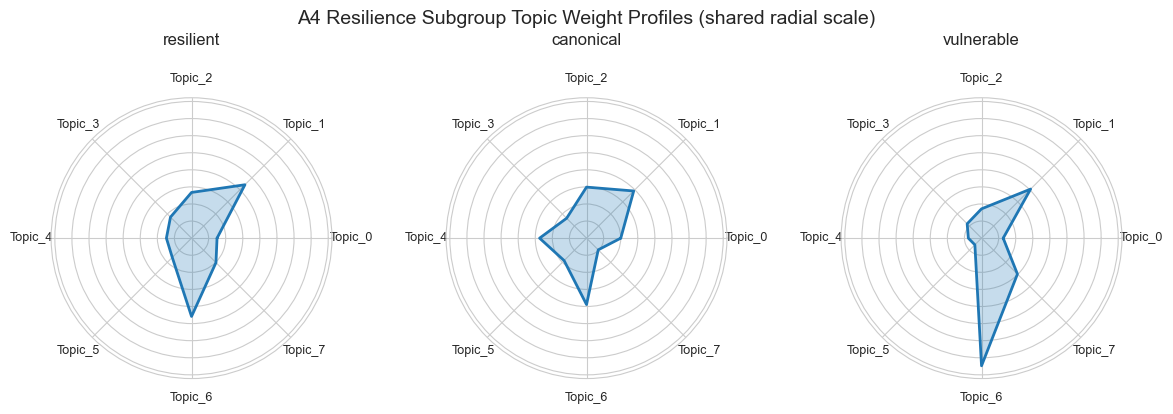

KeyError: None

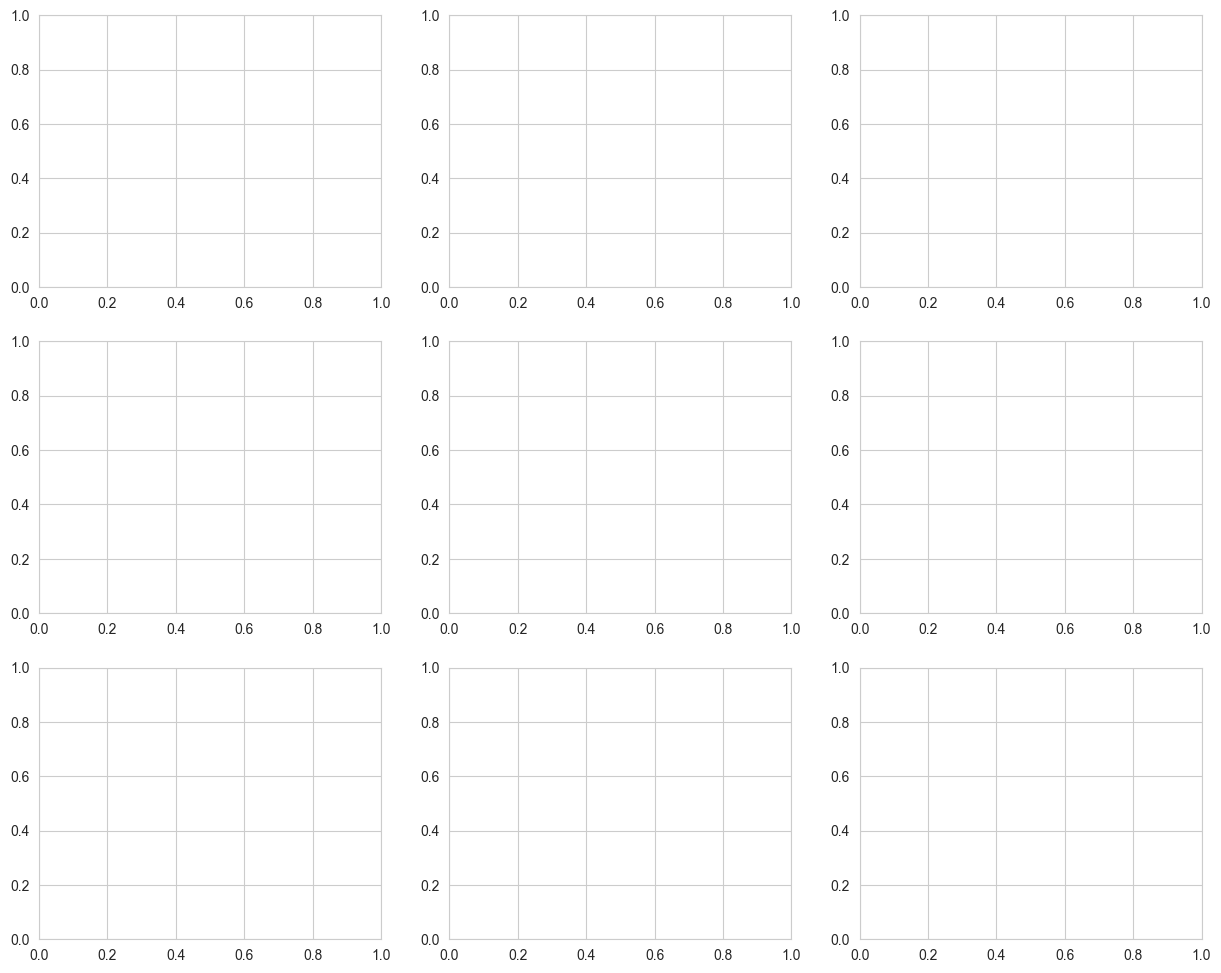

In [70]:
resilient_subgroup_visualization(
    inp_df=plot_df,
    prob_cols=prob_cols,
    group_col=group_col, 
    group_order=group_order,
    cohort='A4',
    scatter_col=None
)